Import packages

In [1]:
from collections import Counter
import math
import os

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyradiobiology import LKB
from pyradiobiology.primitives import Dose, DoseType, DoseBag
import scipy as sp
from scipy import signal
from scipy import stats

To install packages

In [ ]:
# import sys
# %conda install --yes --prefix {sys.prefix} scipy

# Apparently this package requires pip
# %pip install pyradiobiology

Set global variables

In [10]:
# PROJECT_DATA = os.path.join('jolien', 'Anonymized_planned_vs_delivered_dose_accumulation_data')
# INPUT_DIR = os.path.join('input_data', PROJECT_DATA)
INPUT_DIR = 'Anonymized_planned_vs_delivered_dose_accumulation_data'

ADAPTED_PATIENTS = [
    'a12d277b',
    'a6cecdc7',
    '0f21acd5',
    'c85c425b',
    '9b6b2bfa',
    '584a5f6f',
    '7a2278da',
    '65079eb2',
    '18a10b59',
    '80b18507',
    '5637a8a5',
    '4165ec7b',
    '3b0c9681',
    '6051d40d',
    'd87618b0',
    '152f067b',
    '2dfb48cd',
    '06bd9ded',
    '471c7d66',
    '9bf04b57',
    'a5495951',
    'b861a48f',
    'e19eaf8c',
    '8da2af5c',
    '113c1741'
]

JOLIEN_52_PATIENTS = [
    'a12d277b',
    '201f060a',
    '31c6b8d5',
    '3915799f',
    'e32e1305',
    'bc13da51',
    'f9e5560a',
    'c6293de3',
    'f7067398',
    'e4229483',
    'efe3982f',
    'a398bdd2',
    '3c0606a7',
    '2e33a8ad',
    '9ef3cb1b',
    '0f21acd5',
    '7282758',
    '76ec4dea',
    'e847c8ca',
    '60372aa9',
    '7880afe2',
    'c85c425b',
    '08de11ea',
    'e89a311a',
    'bd33c435',
    '056aea4e',
    '0c51fd88',
    '7a2278da',
    '166493de',
    '2a07099e',
    '7c585a17',
    '65079eb2',
    '59502baa',
    '18a10b59',
    'd0b2d3fc',
    '05b340b2',
    '73f7595e',
    '3502872b',
    '80b18507',
    '3b53be84',
    '2d67c27f',
    '4165ec7b',
    '6051d40d',
    '6ab636a3',
    '152f067b',
    '471c7d66',
    '4d999226',
    '9bf04b57',
    'f8a1cef0',
    'b861a48f',
    'e19eaf8c',
    '8da2af5c'
]

ADAPTED_PATIENTS_NOT_IN_JOLIEN_PATIENTS = [
    '113c1741', '5637a8a5', 'a6cecdc7', '2dfb48cd', '9b6b2bfa', '3b0c9681', 'd87618b0', 'a5495951', '584a5f6f', '06bd9ded'
]

JOLIEN_PATIENTS_FOLDER_MISSING = [
    '7282758'
]

JOLIEN_PATIENTS_FOLDER_INCLUDED = [
    'a12d277b',
    '201f060a',
    '31c6b8d5',
    '3915799f',
    'e32e1305',
    'bc13da51',
    'f9e5560a',
    'c6293de3',
    'f7067398',
    'e4229483',
    'efe3982f',
    'a398bdd2',
    '3c0606a7',
    '2e33a8ad',
    '9ef3cb1b',
    '0f21acd5',
    '76ec4dea',
    'e847c8ca',
    '60372aa9',
    '7880afe2',
    'c85c425b',
    '08de11ea',
    'e89a311a',
    'bd33c435',
    '056aea4e',
    '0c51fd88',
    '7a2278da',
    '166493de',
    '2a07099e',
    '7c585a17',
    '65079eb2',
    '59502baa',
    '18a10b59',
    'd0b2d3fc',
    '05b340b2',
    '73f7595e',
    '3502872b',
    '80b18507',
    '3b53be84',
    '2d67c27f',
    '4165ec7b',
    '6051d40d',
    '6ab636a3',
    '152f067b',
    '471c7d66',
    '4d999226',
    '9bf04b57',
    'f8a1cef0',
    'b861a48f',
    'e19eaf8c',
    '8da2af5c'
]

JOLIEN_PATIENTS_WITH_PAROTID = [
    'a12d277b',
    '201f060a',
    '31c6b8d5',
    '3915799f',
    'e32e1305',
    'bc13da51',
    'f9e5560a',
    'c6293de3',
    'f7067398',
    'e4229483',
    'efe3982f',
    'a398bdd2',
    '3c0606a7',
    '2e33a8ad',
    '9ef3cb1b',
    '0f21acd5',
    '76ec4dea',
    'e847c8ca',
    '7880afe2',
    'c85c425b',
    '08de11ea',
    'e89a311a',
    'bd33c435',
    '056aea4e',
    '0c51fd88',
    '7a2278da',
    '2a07099e',
    '7c585a17',
    '18a10b59',
    'd0b2d3fc',
    '05b340b2',
    '73f7595e',
    '3502872b',
    '80b18507',
    '3b53be84',
    '2d67c27f',
    '4165ec7b',
    '6051d40d',
    '6ab636a3',
    '152f067b',
    '471c7d66',
    '9bf04b57',
    'f8a1cef0',
    'b861a48f',
    'e19eaf8c',
    '8da2af5c'
]

# patients_missing_parotid = ['60372aa9', '166493de','65079eb2','59502baa','4d999226']

Check which adapted patients are not in the final 52

In [59]:
# set(ADAPTED_PATIENTS).issubset(set(ALL_PATIENTS))
adapt_not_in_52 = set(ADAPTED_PATIENTS).difference(set(JOLIEN_52_PATIENTS))
print(adapt_not_in_52) # {'113c1741', '5637a8a5', 'a6cecdc7', '2dfb48cd', '9b6b2bfa', '3b0c9681', 'd87618b0', 'a5495951', '584a5f6f', '06bd9ded'}

{'113c1741', '5637a8a5', 'a6cecdc7', '2dfb48cd', '9b6b2bfa', '3b0c9681', 'd87618b0', 'a5495951', '584a5f6f', '06bd9ded'}


Check which patients from the 52 are not in the dataset we have

In [60]:
all_patients_dir = os.listdir(INPUT_DIR)
all_patients_dir = [f for f in all_patients_dir if f[0] != '.'] # ignore hidden files/directories
# set(JOLIEN_52_PATIENTS).issubset(set(all_patients_dir))
patients_not_in_dir = set(JOLIEN_52_PATIENTS).difference(set(all_patients_dir))
print(patients_not_in_dir) # {'7282758'}

{'7282758'}


## Define NTCP Models

In [4]:
def calculate_NTCP_LKB(doses, volumes, td50, m, n, ab_ratio, nfx):
    """
    Calculate the NTCP for a given patient using the Lyman-Kutcher-Burman (LKB) model.

    Parameters
    ----------
    doses : np.array[float]
        The dDVH doses in Gy.
    volumes : np.array[float]
        The dDVH volumes for each dose in cc.
    td50 : float
        The uniform dose to the whole organ resulting in 50% complication probability.
    m : float
        The slope of the NTCP curve.
    n : float
        The volume dependency parameter (n = 1 is the mean dose model).
    ab_ratio : float
        The a/B ratio of the tissue of interest.
    nfx : int
        The number of fractions for the treatment.
    verbose : bool, optional
        Whether to print the computed results (`True`) or not (`False`).

    Returns
    -------
    NTCPs : np.array[float]
        The predicted NTCP using the LKB method.

    """
    # From https://doi.org/10.1016%2Fj.ijrobp.2009.07.1708 (for parotid):
    #   td50 = 39.9 Gy
    #   m = 0.4
    #   n = 1 (mean dose)
    # Other:
    #   a/B = 3
    lkb_model = LKB(td50=Dose.gy(td50, dose_type=DoseType.EQD2), m=m, n=n)
    NTCP = 100 * lkb_model.response_from_pysical_dose(
        dose_array_in_physical_dose = DoseBag.create(data=doses, dose_type=DoseType.PHYSICAL_DOSE),
        volume_array = volumes,
        ab_ratio = Dose.gy(ab_ratio),
        nfx = nfx
    )
    return NTCP

# def calculate_NTCP_Lee(mean_ipsalateral_parotid_dose, mean_contralateral_parotid_dose):
    # For the 3-month time point: S = −32.29 + (Dmean-c*0.637) + (Dmean-i*0.185) + (age*0.202)
    # For the 12-month time point: S = −44.87+ (Dmean-c*1.400) + (Dmean-i*0.358) + (T stage*corresponding coefficient);

def calculate_NTCP_Beetz(mean_contralateral_parotid_dose, baseline_xerostomia_score):
    """
    Calculate the NTCP for a given patient using the Beetz et al., 2012 paper.

    Parameters
    ----------
    mean_contralateral_parotid_dose : np.ndarray
        The mean dose to the contralateral parotid gland.
    baseline_xerostomia_score : np.ndarray
        The baseline xerostomia score (on a 4-point scale, I believe).
    verbose : bool, optional
        Whether to print the computed results (`True`) or not (`False`).

    Returns
    -------
    NTCP : float
        The predicted NTCP using the Beetz method.

    """
    S = -1.443 + (mean_contralateral_parotid_dose * 0.047) + (baseline_xerostomia_score * 0.720)
    NTCP = 100 * (1 + math.exp(-S))**(-1)
    return NTCP

## NTCP Plot Example

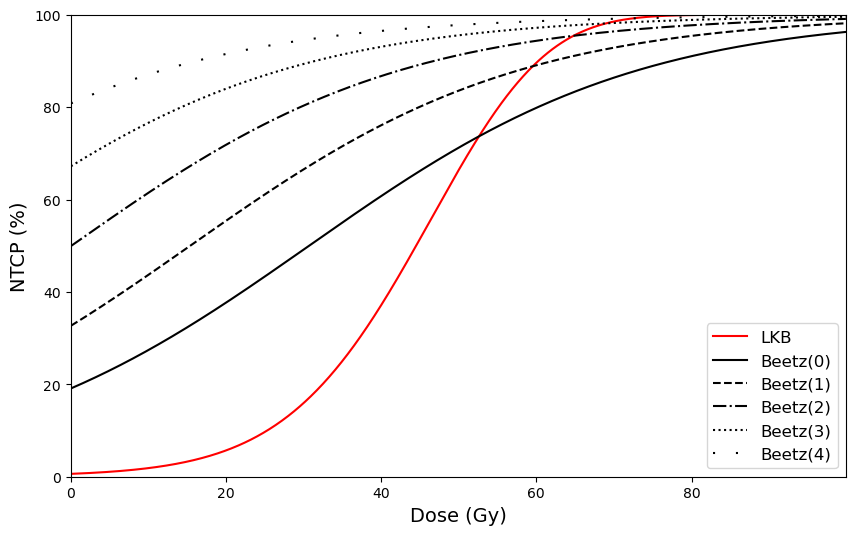

In [143]:
# Fake dose data
doses = np.arange(0,100,0.1)

all_linestyles = ['-','--','-.',':',(0,(1,10))]
plt.figure(figsize=(10,6))
# LKB
all_NTCPs_LKB = [calculate_NTCP_LKB([d], [1], 39.9, 0.4, 1, 3, 30) for d in doses]
plt.plot(doses, all_NTCPs_LKB, color='r', label='LKB')
# Beetz
for i,baseline_xerostomia_score in enumerate([0,1,2,3,4]):
    baseline_xerostomia_scores = baseline_xerostomia_score * np.ones(len(doses))
    all_NTCPs = [calculate_NTCP_Beetz(d,s) for d,s in zip(doses, baseline_xerostomia_scores)]
    plt.plot(doses, all_NTCPs, color='k', linestyle=all_linestyles[i], label=f'Beetz({baseline_xerostomia_score})')

plt.xlabel('Dose (Gy)', fontsize=14)
plt.ylabel('NTCP (%)', fontsize=14)
plt.xlim([0,max(doses)])
plt.ylim([0,100])
plt.legend(fontsize=12)
plt.show()

## Accumulate DVHs

In [19]:
def convolve_DVHs(total_dose, fx_dose):
    conv_dose = np.convolve(fx_dose, total_dose, mode='full')[0:len(fx_dose)]
    cumsum_conv = np.cumsum(conv_dose[::-1])[::-1]
    plot_conv_dose = (cumsum_conv - np.min(cumsum_conv)) / (np.max(cumsum_conv) - np.min(cumsum_conv))
    new_total_dose = -np.diff(plot_conv_dose)
    return plot_conv_dose, new_total_dose

def compute_dose_at_fx(total_dose, fx_dose, current_fx, final_fx):
    new_total_dose = total_dose
    remaining_fx = final_fx - current_fx
    for _ in range(remaining_fx):
        plot_conv_dose, new_total_dose = convolve_DVHs(new_total_dose, fx_dose)
        # conv_dose = np.convolve(fx_dose, total_dose, mode='full')[0:len(fx_dose)]
        # cumsum_conv = np.cumsum(conv_dose[::-1])[::-1]
        # plot_conv_dose = (cumsum_conv - np.min(cumsum_conv)) / (np.max(cumsum_conv) - np.min(cumsum_conv))
        # total_dose = -np.diff(plot_conv_dose)
        # # plt.plot(x, plot_conv_dose, label=f'Predicted Dose fx: {current_fx+i+1}')
    return plot_conv_dose, new_total_dose

Test functions on dummy data

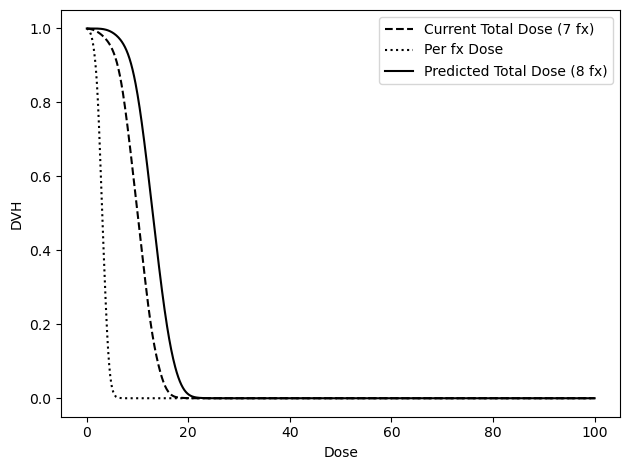

In [33]:
current_fx = 7
final_fx = 8
d1 = np.random.normal(3,1,1000)
x = np.linspace(0, 100, 1000)
total_dose = sp.stats.gaussian_kde(np.array(np.random.normal(10,3,1000)))(x)
fx_dose = sp.stats.gaussian_kde(np.array(d1))(x)

plt.figure()
cumsum_total_dose = np.cumsum(total_dose[::-1])[::-1]
cumsum_fx_dose = np.cumsum(fx_dose[::-1])[::-1]
plot_total_dose = (cumsum_total_dose-np.min(cumsum_total_dose))/(np.max(cumsum_total_dose)-np.min(cumsum_total_dose))
plot_fx_dose = (cumsum_fx_dose-np.min(cumsum_fx_dose))/(np.max(cumsum_fx_dose)-np.min(cumsum_fx_dose))
plt.plot(x, plot_total_dose, color='k', linestyle='--', label=f'Current Total Dose ({current_fx} fx)')
plt.plot(x, plot_fx_dose, color='k', linestyle=':', label='Per fx Dose')
predicted_total_dose,_ = compute_dose_at_fx(total_dose, fx_dose, current_fx, final_fx)
plt.plot(x, predicted_total_dose, color='k', label=f'Predicted Total Dose ({final_fx} fx)')


# plt.plot(x, nconv, color='k', label='Actual Accumulated Dose')
plt.xlabel('Dose')
plt.ylabel('DVH')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## Compute doses and NTCPs for a patient

NTCP_fx Fx 15 = 0.67%
NTCP_accum Fx 15 = 2.30%


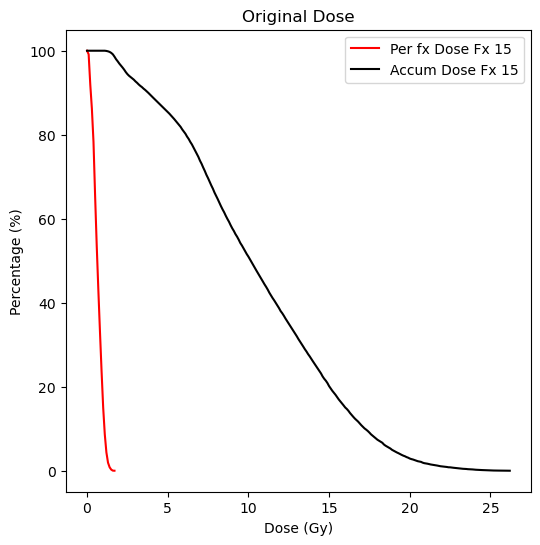

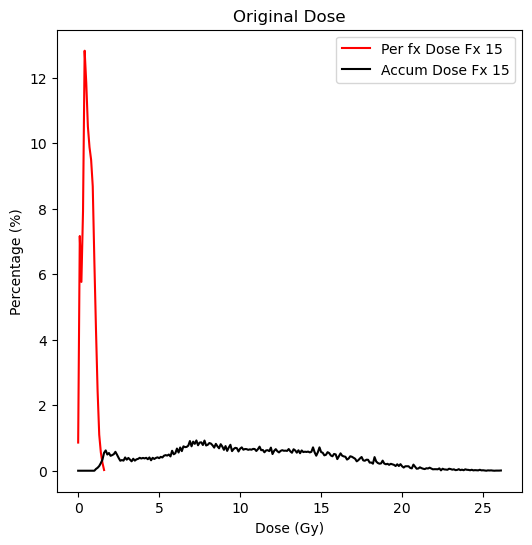

NTCP_predicted (at end of treatment) Fx 15 = 5.36%


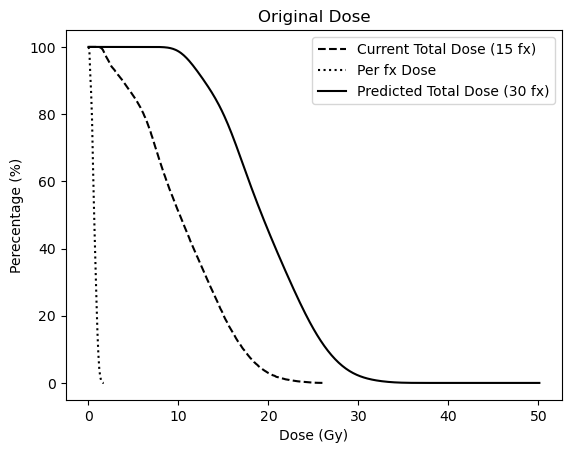

In [60]:
patient = '0c51fd88' # right parotid
# patient = 'a12d277b'  # R parotid
# dose_type = 'fx'
group_name = 'Original' # Planned dose = 'Original'; Delivered dose = 'RTS'
# left_parotid_name = 'left parotid'
right_parotid_name = 'right parotid'
# From https://doi.org/10.1016%2Fj.ijrobp.2009.07.1708 (for parotid):
td50 = 39.9     # Gy
m = 0.4
n = 1           # Mean dose if n = 1
# Other:
aB_ratio = 3

parotid_names = [
    'right parotid','R parotid','Rt parotid','parotid_r','RParotid','6b Rt Parotid','R Parotid','Parotid rt',
    'Rt Parotid -15','Rt Parotid','Right parotid','R PAROTID','RT parotid','rt parotid','RT PAROTID'
]

# Grab all dvh files (fx and accumulated dose)
# Assumes the folder doesn't contain the csv files yet
all_fx_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' in f]
all_accum_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' not in f]
assert len(all_accum_files) == len(all_fx_files)
nfx = len(all_fx_files)
# Grab all dvh files (fx and accumulated dose) with .csv extension
all_fx_files = [f'RD.Accumulated.{i+1}.fx.dcm dvh {group_name.lower()}.csv' for i in range(nfx)] # this sorts the fx no
all_accum_files = [f'RD.Accumulated.{i+1}.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]

fx_no = 15
df_fx = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_fx_files[fx_no]))
# Get only the desired structures
parotid_found = False
for name in parotid_names:
    if np.any(np.where(df_fx.columns == name)[0]): # if list not empty
        right_parotid_name = name
        parotid_found = True
        break
if not parotid_found:
    print(f"\t\tFx {fx_no+1}. Right parotid column name not found.")
    print("\t\t", os.path.join(INPUT_DIR,patient,group_name,all_fx_files[fx_no]))
vol_ind_fx = np.where(df_fx.columns == right_parotid_name)[0][0]+1
# print("Fx column index ", np.where(df_fx.columns == right_parotid_name)[0][0]+1)
# vol_col_fx = df_fx.columns[vol_ind_fx]
# vol_fx = float(vol_col_fx)
dvh_fx = df_fx[right_parotid_name]
dose_fx = np.array(dvh_fx/100) # since it is given in cGy
vol_percent_fx = np.array(df_fx.iloc[:,vol_ind_fx])
# print(len(vol_percent_fx)) # the fx and accumulation may have different lengths
# dDVH
dDVH_dose_fx = dose_fx[~np.isnan(dose_fx)][:-1]
dDVH_vol_percent_fx = -np.diff(vol_percent_fx)
dDVH_vol_percent_fx = dDVH_vol_percent_fx[~np.isnan(dDVH_vol_percent_fx)] # keep non-NaN values
# NTCP (from just this fraction)
NTCP_fx = calculate_NTCP_LKB(dDVH_dose_fx, dDVH_vol_percent_fx, td50, m, n, aB_ratio, 1) # one since just considering this fx
print(f'NTCP_fx Fx {fx_no} = {NTCP_fx:.2f}%')

# fx_no = 15
df_accum = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_accum_files[fx_no]))
# Get only the desired structures
vol_ind_accum = np.where(df_accum.columns == right_parotid_name)[0][0]+1
# print("Accum column index ", np.where(df_fx.columns == right_parotid_name)[0][0]+1)
# vol_col_accum = df_accum.columns[vol_ind_accum]
# vol_accum = float(vol_col_accum)
dvh_accum = df_accum[right_parotid_name]
dose_accum = np.array(dvh_accum/100)
vol_percent_accum = np.array(df_accum.iloc[:,vol_ind_accum])
# print(len(vol_percent_accum))
# dDVH
dDVH_dose_accum = dose_accum[~np.isnan(dose_accum)][:-1]
dDVH_vol_percent_accum = -np.diff(vol_percent_accum)
dDVH_vol_percent_accum = dDVH_vol_percent_accum[~np.isnan(dDVH_vol_percent_accum)] # keep non-NaN values
# NTCP (all doses up to this fraction)
NTCP_accum = calculate_NTCP_LKB(dDVH_dose_accum, dDVH_vol_percent_accum, td50, m, n, aB_ratio, fx_no) # nfx replaced 1
print(f'NTCP_accum Fx {fx_no} = {NTCP_accum:.2f}%')

# Plots
plt.figure(figsize=(6,6))
plt.plot(dose_fx, 100*vol_percent_fx, 'r', label=f'Per fx Dose Fx {fx_no}')
plt.plot(dose_accum, 100*vol_percent_accum, 'k', label=f'Accum Dose Fx {fx_no}')
plt.legend()
plt.xlabel('Dose (Gy)')
plt.ylabel('Percentage (%)')
plt.title(f'{group_name} Dose')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(dDVH_dose_fx, 100*dDVH_vol_percent_fx, 'r', label=f'Per fx Dose Fx {fx_no}')
plt.plot(dDVH_dose_accum, 100*dDVH_vol_percent_accum, 'k', label=f'Accum Dose Fx {fx_no}')
plt.legend()
plt.xlabel('Dose (Gy)')
plt.ylabel('Percentage (%)')
plt.title(f'{group_name} Dose')
plt.show()

x = np.arange(0, 200, 0.1)
current_fx = 15
final_fx = 30
# vol_percent_accum = np.pad(vol_percent_accum, (0,len(x)-len(vol_percent_accum)), 'constant') # add 0's to fit in graph?
# vol_percent_fx_ = np.pad(vol_percent_fx, (0,len(x)-len(vol_percent_fx)), 'constant')
plt.plot(x[:len(vol_percent_accum)], 100*vol_percent_accum, color='k', linestyle='--', label=f'Current Total Dose ({current_fx} fx)')
plt.plot(x[:len(vol_percent_fx)], 100*vol_percent_fx, color='k', linestyle=':', label='Per fx Dose')
dDVH_vol_percent_accum_padded = np.pad(dDVH_vol_percent_accum, (0,len(x)-len(dDVH_vol_percent_accum)), 'constant')
dDVH_vol_percent_fx_padded = np.pad(dDVH_vol_percent_fx, (0,len(x)-len(dDVH_vol_percent_fx)), 'constant')
# compute_dose_at_fx(total_dose, fx_dose, current_fx, final_fx)
vol_percent_predicted, dDVH_percent_predicted  = compute_dose_at_fx(dDVH_vol_percent_accum_padded, dDVH_vol_percent_fx_padded, current_fx, final_fx)
NTCP_predicted = calculate_NTCP_LKB(x[:len(dDVH_percent_predicted)], dDVH_percent_predicted, td50, m, n, aB_ratio, nfx)
print(f'NTCP_predicted (at end of treatment) Fx {fx_no} = {NTCP_predicted:.2f}%')
right_most_ind = np.argmin(vol_percent_predicted)
plt.plot(x[:right_most_ind], 100*vol_percent_predicted[:right_most_ind], color='k', label=f'Predicted Total Dose ({final_fx} fx)')
plt.legend()
plt.xlabel('Dose (Gy)')
plt.ylabel('Perecentage (%)')
plt.title(f'{group_name} Dose')
plt.show()

## Compute planned and delivered doses and NTCPs (LKB) for all patients

Code to explore what the values are

In [ ]:
all_patients = os.listdir(INPUT_DIR)
all_patients = [f for f in all_patients if f[0] != '.'] # ignore hidden files/directories
print(all_patients)
print(len(all_patients))
groups = ['Original', 'RTS']

# nonempty_patients = {}
nfxs = []
for patient in JOLIEN_PATIENTS_FOLDER_INCLUDED: # all_patients:
    for group_name in groups:
        # Grab all dvh files (fx and accumulated dose)
        # Assumes the folder doesn't contain the csv files yet
        all_fx_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' in f]
        all_accum_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' not in f]
        # print(all_fx_files)
        assert len(all_accum_files) == len(all_fx_files)
        nfx = len(all_fx_files)
        # if nfx > 0:
        #     nonempty_patients[patient] = nfx
        #     nfxs.append(nfx)
        # nonempty_patients[patient] = nfx
        nfxs.append(nfx)
        # # Grab all dvh files (fx and accumulated dose) with .csv extension
        all_fx_files_2 = [f'RD.Accumulated.{i+1}.fx.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]
        # print(all_fx_files_2)
        all_accum_files_2 = [f'RD.Accumulated.{i+1}.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]
        assert sorted(all_fx_files_2) == sorted(all_fx_files)
        assert sorted(all_accum_files_2) == sorted(all_accum_files_2)
# Fileanames are the same but those with _2 suffix are in order



### Compute NTCPs using LKB from 'Anonymized_planned_vs_delivered_dose_accumulation_data'

In [53]:
# all_patients = os.listdir(INPUT_DIR)
# all_patients = [f for f in all_patients if f[0] != '.'] # ignore hidden files/directories
all_patients = JOLIEN_PATIENTS_WITH_PAROTID
groups = ['Original', 'RTS']
# left_parotid_name = 'left parotid'
# right_parotid_name = 'right parotid'
# From https://doi.org/10.1016%2Fj.ijrobp.2009.07.1708 (for parotid):
td50 = 39.9     # Gy
m = 0.4
n = 1           # Mean dose if n = 1
# Other:
aB_ratio = 3
max_no_fx = 36

parotid_names = [
    'right parotid','R parotid','Rt parotid','parotid_r','RParotid','6b Rt Parotid','R Parotid','Parotid rt',
    'Rt Parotid -15','Rt Parotid','Right parotid','R PAROTID','RT parotid','rt parotid','RT PAROTID',
]

#### Patients for which loading didn't work and why
bad_patients = ['3c0606a7','9bf04b57']
# '3c0606a7' , 'RD.Accumulated.10.dcm dvh rts' file is messed up
# '9bf04b57', 'RD.Accumulated.14.dcm dvh rts' files is messed up
# patients_missing_parotid = ['60372aa9', '166493de','65079eb2','59502baa','4d999226']

# patients_checked = ['a12d277b', '201f060a', '31c6b8d5', '3915799f', 'e32e1305', 'bc13da51', 'f9e5560a', 'c6293de3', 'f7067398', 
# 'e4229483', 'efe3982f', 'a398bdd2', '3c0606a7', '2e33a8ad', '9ef3cb1b', '0f21acd5', '76ec4dea', 'e847c8ca', '7880afe2', 'c85c425b', 
# '08de11ea', 'e89a311a', 'bd33c435', '056aea4e', '0c51fd88', '7a2278da', '2a07099e', '7c585a17', '18a10b59', 'd0b2d3fc', '05b340b2', 
# '73f7595e', '3502872b', '80b18507', '3b53be84', '2d67c27f', '4165ec7b', '6051d40d', '6ab636a3', '152f067b', '471c7d66', '9bf04b57', 
# 'f8a1cef0', 'b861a48f', 'e19eaf8c', '8da2af5c']
# patients_checked = []

all_patients_NTCPs_predicted = {}
for patient in all_patients: # all_patients:
    # if patient != '9bf04b57': # to check a particular patient
    #     continue
    # print(patient)
    if patient in bad_patients:
        continue

    patient_NTCPs_predicted = {}
    for group_name in groups:
        # print("\t", group_name)
        # Grab all dvh files (fx and accumulated dose)
        # Assumes the folder doesn't contain the csv files yet
        all_fx_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' in f]
        all_accum_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' not in f]
        assert len(all_accum_files) == len(all_fx_files)
        nfx = len(all_fx_files)
        # # Grab all dvh files (fx and accumulated dose) with .csv extension (they are the same in this case)
        all_fx_files = [f'RD.Accumulated.{i+1}.fx.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]
        all_accum_files = [f'RD.Accumulated.{i+1}.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]

        parotid_found = False
        NTCPs_fx = []
        NTCPs_predicted = []
        # print(f"{group_name}: ", end =" ")
        for fx_no in range(nfx):
            # print(f"{fx_no+1} - ", end =" ")
            df_fx = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_fx_files[fx_no]))

            #### Get only the desired structures

            # This assumes the parotid name remains the same for all fx files 
            # If not, simply uncomment the next line and remove this 'if' to run the block at each fraction
            # parotid_found = False
            if not parotid_found:  # this assumes the parotid name remains the same for all fx files (if not, simply remove this 'if' and run the block to check at each fraction)
                for name in parotid_names:
                    if np.any(np.where(df_fx.columns == name)[0]): # if list not empty
                        actual_right_parotid_name = name
                        parotid_found = True
                        break
                
                if not parotid_found:
                    print(f"\t\tFx {fx_no+1}. Right parotid column name not found.")
                    print("\t\t", os.path.join(INPUT_DIR,patient,group_name,all_fx_files[fx_no]))
                    break
            
            #### Fx data
            # vol_ind_fx = np.where(df_fx.columns == right_parotid_name)[0][0]+1
            vol_ind_fx = np.where(df_fx.columns == actual_right_parotid_name)[0][0]+1
            # dvh_fx = df_fx[right_parotid_name]
            dvh_fx = df_fx[actual_right_parotid_name]
            dose_fx = np.array(dvh_fx/100) # because it is given in cGy?
            vol_percent_fx = np.array(df_fx.iloc[:,vol_ind_fx])
            # dDVH
            dDVH_dose_fx = dose_fx[~np.isnan(dose_fx)][:-1]
            dDVH_vol_percent_fx = -np.diff(vol_percent_fx)
            dDVH_vol_percent_fx = dDVH_vol_percent_fx[~np.isnan(dDVH_vol_percent_fx)] # keep non-NaN values
            # NTCP (from just this fraction)
            # NTCP_fx = calculate_NTCP_LKB(dDVH_dose_fx, dDVH_vol_percent_fx, td50, m, n, aB_ratio, 1) # 1 since just considering this fx
            # print(f'{group_name} NTCP fx {fx_no} = {NTCP_fx:.2f}%')
            # NTCPs_fx.append(NTCP_fx)

            #### Accumulated data
            df_accum = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_accum_files[fx_no]))
            # vol_ind_accum = np.where(df_accum.columns == right_parotid_name)[0][0]+1
            vol_ind_accum = np.where(df_accum.columns == actual_right_parotid_name)[0][0]+1
            # vol_col_accum = df_accum.columns[vol_ind_accum]
            # vol_accum = float(vol_col_accum)
            # dvh_accum = df_accum[right_parotid_name]
            dvh_accum = df_accum[actual_right_parotid_name]
            dose_accum = np.array(dvh_accum/100)
            vol_percent_accum = np.array(df_accum.iloc[:,vol_ind_accum])
            # print(len(vol_percent_accum))
            # dDVH
            dDVH_dose_accum = dose_accum[~np.isnan(dose_accum)][:-1]
            dDVH_vol_percent_accum = -np.diff(vol_percent_accum)
            dDVH_vol_percent_accum = dDVH_vol_percent_accum[~np.isnan(dDVH_vol_percent_accum)] # keep non-NaN values
            # NTCP (all doses up to this fraction)
            # NTCP_accum = calculate_NTCP_LKB(dDVH_dose_accum, dDVH_vol_percent_accum, td50, m, n, aB_ratio, fx_no)
            # print(f'NTCP_accum Fx {fx_no} = {NTCP_accum:.2f}%')
            # NTCPs_fx.append(NTCP_fx)

            #### NTCP (predicted by end of treatment)
            dDVH_vol_percent_accum_padded = np.pad(dDVH_vol_percent_accum, (0,len(x)-len(dDVH_vol_percent_accum)), 'constant')
            dDVH_vol_percent_fx_padded = np.pad(dDVH_vol_percent_fx, (0,len(x)-len(dDVH_vol_percent_fx)), 'constant')
            vol_percent_predicted, dDVH_percent_predicted  = compute_dose_at_fx(dDVH_vol_percent_accum_padded, dDVH_vol_percent_fx_padded, current_fx, final_fx)
            NTCP_predicted = calculate_NTCP_LKB(x[:len(dDVH_percent_predicted)], dDVH_percent_predicted, td50, m, n, aB_ratio, nfx)
            NTCPs_predicted.append(NTCP_predicted)
        
        # Requires fractions to be in order
        patient_NTCPs_predicted[f"{group_name}"] = NTCPs_predicted

    # patients_checked.append(patient)
    # print(patients_checked)
    patient_NTCPs_predicted["Diffs"] = [a_i - b_i for a_i, b_i in zip(patient_NTCPs_predicted['RTS'], patient_NTCPs_predicted['Original'])]
    # patient_NTCPs["Diffs"] = np.subtract(patient_NTCPs['RTS'], patient_NTCPs['Original']).tolist()
    all_patients_NTCPs_predicted[patient] = patient_NTCPs_predicted
    # print(patient_NTCPs, "\n")

a12d277b
201f060a
31c6b8d5
3915799f
e32e1305
bc13da51
f9e5560a
c6293de3
f7067398
e4229483
efe3982f
a398bdd2
3c0606a7
2e33a8ad
9ef3cb1b
0f21acd5
76ec4dea
e847c8ca
7880afe2
c85c425b
08de11ea
e89a311a
bd33c435
056aea4e
0c51fd88
7a2278da
2a07099e
7c585a17
18a10b59
d0b2d3fc
05b340b2
73f7595e
3502872b
80b18507
3b53be84
2d67c27f
4165ec7b
6051d40d
6ab636a3
152f067b
471c7d66
9bf04b57
f8a1cef0
b861a48f
e19eaf8c
8da2af5c


In [55]:
# TODO: Questions/Concerns:
# NTCPs may be incorrect, I hypothesize due to padding
    # For example, for patient 3b53be84, the RTS accum dose is greater than Original accum dose, but the NTCP for RTS is lower
# I am using NTCP LKB. There is also Beetz
# There are other parotid values, such as right parotid sub, right parotid tail
# Some individuals are missing right parotid values
# There are two corrupt files (see bad_patients)
# There is one patient in Jolien's final data set that is not in the 'Anonymized_planned_vs_delivered_dose_accumulation_data' folder
# The 'new_original_csv_files_only_parotid' folder Cem sent has the dose files but without the Original and RTS folders, and 
    # it is not specified if these files are Original or RTS
# Need to figure out how to place each patient's data as a row in a DataFame
# TODO: General questions from the data set
# Missing patients, interpolation I used, double height values, weight at various time points, steroids

# patient = 'a12d277b'
# patient = '0c51fd88'
bad_patients = ['3c0606a7','9bf04b57']

max_to_show = 100
counter = 0
for patient in JOLIEN_PATIENTS_WITH_PAROTID:
    if patient in bad_patients:
        print(f"Patient: {patient}\n\n")
        continue
    if counter < max_to_show:
        print(f"Patient: {patient}")
        print(f"Planned NTCP (Original): \n\t{all_patients_NTCPs_predicted[patient]['Original']}")
        print(f"Actual NTCP (RTS): \n\t{all_patients_NTCPs_predicted[patient]['RTS']}")
        print(f"Differences in NTCP: \n\t{all_patients_NTCPs_predicted[patient]['Diffs']}")
        print("\n")
        counter = counter + 1

Patient: a12d277b
Planned NTCP (Original): 
	[1.890513758017126, 2.0404684871475176, 2.2029389922157696, 2.37878353105595, 2.569000539424576, 2.775090023908855, 2.997986015602544, 3.2384840130025516, 3.498506263765966, 3.7793249084219216, 4.082455967607368, 4.409289725904592, 4.76233350947447, 5.141784304801589, 5.549995368290405, 5.989368761042097, 6.461303267236445, 6.9686717563021805, 7.511807053401448, 8.093907104904252, 8.651839224552194, 9.309086421040435, 10.0112843324487, 10.759973816938745, 11.556990956557584, 12.270153655223309, 13.154781338774345, 14.091343739052409, 15.082892320448593, 16.131112950278958, 17.237677640922293, 18.402258215160682, 19.628076365456632]
Actual NTCP (RTS): 
	[1.890513758017126, 2.0404684871475176, 2.2029389922157696, 2.37878353105595, 2.569000539424576, 2.775090023908855, 2.997986015602544, 3.2384840130025516, 3.498506263765966, 3.7793249084219216, 4.082455967607368, 4.409289725904592, 4.76233350947447, 5.141784304801589, 5.549995368290405, 5.9893

### Compute NTCPs from 'new_original_csv_files_only_parotid'
### Problem: Don't have the Original and RTS folders, and unclear to which these files are from 

In [ ]:
INPUT_DIR = '/Users/raulgarcia/Documents/Rice University/Research/NIH SCH Adaptive Radiation Therapy/Aim 2_POMDP ART/Aim 2 Data/new_original_csv_files_only_parotid/'
all_patients = os.listdir(INPUT_DIR)
all_patients = [f for f in all_patients if f[0] != '.'] # ignore hidden files/directories
print(all_patients)
print(len(all_patients))
groups = ['Original', 'RTS']
left_parotid_name = 'parotid_Lt'
right_parotid_name = 'parotid_Rt'
# From https://doi.org/10.1016%2Fj.ijrobp.2009.07.1708 (for parotid):
td50 = 39.9     # Gy
m = 0.4
n = 1           # Mean dose if n = 1
# Other:
aB_ratio = 3
max_no_fx = 36

# all_patient_NTCPs = {}
# for patient in all_patients:
#     if patient in ['50', '57']:
#         continue

#     ####

## Another approach to compute doses and NTCPs

In [153]:
# cleaned_input_dir = os.path.join('input_data','jolien','anonymized_cleaned_dose')  # is this a separate dataset?
# all_patients = os.listdir(cleaned_input_dir)
cleaned_input_dir = 'Anonymized_planned_vs_delivered_dose_accumulation_data'
all_patients = JOLIEN_PATIENTS_FOLDER_INCLUDED
group_name = 'Original'

all_df_fx = {}
for patient in all_patients:
    all_df_fx[patient] = []
    all_fx_files = [f for f in os.listdir(os.path.join(cleaned_input_dir, patient, group_name)) if '.fx.' in f]
    nfx = len(all_fx_files)
    all_fx_files = [f'RD.Accumulated.{i+1}.fx.dcm dvh {group_name.lower()}.csv' for i in range(nfx)] # for ordering
    for fx in range(nfx):
        all_df_fx[patient].append(pd.read_csv(os.path.join(cleaned_input_dir, patient, group_name, all_fx_files[fx])).dropna())

all_df_accum = {}
for patient in all_patients:
    all_df_accum[patient] = []
    all_accum_files = [f for f in os.listdir(os.path.join(cleaned_input_dir, patient, group_name)) if '.fx.' not in f]
    nfx = len(all_accum_files)
    all_accum_files = [f'RD.Accumulated.{i+1}.dcm dvh {group_name.lower()}.csv' for i in range(nfx)] # for ordering
    for fx in range(nfx):
        all_df_accum[patient].append(pd.read_csv(os.path.join(cleaned_input_dir, patient, group_name, all_accum_files[fx])).dropna())

# all_adapted_df_fx = {}
# for patient in ADAPTED_PATIENTS:
#     all_adapted_df_fx[patient] = []
#     all_adapted_fx_files = [f for f in os.listdir(os.path.join(cleaned_input_dir,patient)) if '.fx.' in f]
#     nfx = len(all_adapted_fx_files)
#     for fx in range(nfx):
#         all_adapted_df_fx[patient].append(pd.read_csv(os.path.join(cleaned_input_dir, patient, all_adapted_fx_files[fx])).dropna())

# all_adapted_df_accum = {}
# for patient in ADAPTED_PATIENTS:
#     all_adapted_df_accum[patient] = []
#     all_adapted_accum_files = [f for f in os.listdir(os.path.join(cleaned_input_dir,patient)) if '.fx.' not in f]
#     nfx = len(all_adapted_accum_files)
#     for fx in range(nfx):
#         all_adapted_df_accum[patient].append(pd.read_csv(os.path.join(cleaned_input_dir, patient, all_adapted_accum_files[fx])).dropna())

### Compute NTCPs

In [ ]:
# cleaned_input_dir = os.path.join('input_data','jolien','anonymized_cleaned_dose')
# all_patients = os.listdir(cleaned_input_dir)
all_patients = JOLIEN_PATIENTS_WITH_PAROTID
patients_missing_parotid = ['60372aa9', '166493de','65079eb2','59502baa','4d999226']
bad_patients = ['3c0606a7','9bf04b57']

# Names of the desired structures in the CSV files
# parotid_names = ['Parotid_Lt', 'Parotid_Rt']
parotid_names = [
    'right parotid','R parotid','Rt parotid','parotid_r','RParotid','6b Rt Parotid',
    'R Parotid','Parotid rt','Rt Parotid -15','Rt Parotid','Right parotid','R PAROTID',
    'RT parotid','rt parotid','RT PAROTID'
]
baseline_xerostomia_score = 0

# For the LKB NTCP model
# From https://doi.org/10.1016%2Fj.ijrobp.2009.07.1708 (for parotid):
td50 = 39.9     # Gy
m = 0.4
n = 1           # Mean dose if n = 1
# Other:
aB_ratio = 3

# TODO: remove the guess-work and parse the final accumulated file
#       to get the maximum dose range
x = np.arange(0, 200, 0.1)

structure_consistency = 'right parotid'
fx_info_cleaned = {}
for p,patient in enumerate(all_patients):
    if patient in bad_patients:
        continue

    parotid_found = False
    nfx = len(all_df_fx[patient])
    fx_info_cleaned[patient] = []
    for fx in range(nfx):
        # print(f'Fx: {fx} DONE')
        df_fx = all_df_fx[patient][fx]
        # Get the single fraction information
        # NOTE: hack to find out which side is ipsilateral and contralateral until
        #       clinical information is available

        # Get this patient's dose information
        
        # This assumes the parotid name remains the same for all fx files 
        # If not, simply uncomment the next line and remove this 'if' to run the block at each fraction
        # parotid_found = False
        if not parotid_found:  # this assumes the parotid name remains the same for all fx files (if not, simply remove this 'if' and run the block to check at each fraction)
            for name in parotid_names:
                if np.any(np.where(df_fx.columns == name)[0]): # if list not empty
                    actual_right_parotid_name = name
                    parotid_found = True
                    break
            
            if not parotid_found:
                print(f"\t\tFx {fx_no+1}. Right parotid column name not found.")
                print("\t\t", os.path.join(INPUT_DIR,patient,group_name,all_fx_files[fx_no]))
                break

        # #### MY CODE FOR COMPARISON
        # # Get only the desired structures
        # # vol_ind_fx = np.where(df_fx.columns == right_parotid_name)[0][0]+1
        # vol_ind_fx = np.where(df_fx.columns == actual_right_parotid_name)[0][0]+1
        # # vol_col_fx = df_fx.columns[vol_ind_fx]
        # # vol_fx = float(vol_col_fx)
        # # dvh_fx = df_fx[right_parotid_name]
        # dvh_fx = df_fx[actual_right_parotid_name]
        # dose_fx = np.array(dvh_fx/100) # because it is given in cGy?
        # vol_percent_fx = np.array(df_fx.iloc[:,vol_ind_fx])
        # # dDVH
        # dDVH_dose_fx = dose_fx[~np.isnan(dose_fx)][:-1]
        # dDVH_vol_percent_fx = -np.diff(vol_percent_fx)
        # dDVH_vol_percent_fx = dDVH_vol_percent_fx[~np.isnan(dDVH_vol_percent_fx)] # keep non-NaN values
        # ####

        parotid_info = {}
        for structure in [actual_right_parotid_name]: # parotid_names:
            try:
                vol_ind_fx = np.where(df_fx.columns == structure)[0][0] + 1
                # Get the volume of the structure
                # vol_col = df_fx.columns[vol_ind]
                # vol = float(vol_col)
                dvh = df_fx[structure]
                dose_fx = np.array(dvh/100)
                vol_percent_fx = np.array(df_fx.iloc[:,vol_ind_fx])
                # TODO: duplicate work here
                tv_fx = df_fx.iloc[:,[vol_ind_fx-1,vol_ind_fx]].to_numpy()
                mean_dose_fx = np.nansum(np.multiply(tv_fx[:-1,0], -np.diff(tv_fx[:,1])))/100
                # dDVH
                dDVH_dose_fx = dose_fx[~np.isnan(dose_fx)][:-1]
                dDVH_percent_fx = -np.diff(vol_percent_fx)
                dDVH_percent_fx = dDVH_percent_fx[~np.isnan(dDVH_percent_fx)]
                # Zero-pad to length of dose range
                dDVH_percent_fx = np.pad(dDVH_percent_fx, (0,len(x)-len(dDVH_percent_fx)), 'constant')
            except IndexError:
                dose_fx = np.array([0])
                vol_percent_fx = np.array([100])
                mean_dose_fx = 0
                dDVH_percent_fx = np.array([100])

            # Predict the dose at the final fx
            df_accum = all_df_accum[patient][fx]
            # Get only the desired structures
            try:
                vol_ind_accum = np.where(df_accum.columns == structure)[0][0] + 1
                # Get the volume of the structure
                # vol_col_accum = df_accum.columns[vol_ind_accum]
                # vol = float(vol_col_accum)
                # Get the DVH of the structure
                dvh_accum = df_accum[structure]
                dose_accum = np.array(dvh_accum/100)
                vol_percent_accum = np.array(df_accum.iloc[:,vol_ind_accum])
                # TODO: duplicate work here
                tv_accum = df_accum.iloc[:,[vol_ind_accum-1,vol_ind_accum]].to_numpy()
                mean_dose_accum = np.nansum(np.multiply(tv_accum[:-1,0], -np.diff(tv_accum[:,1])))/100
                # dDVH
                dDVH_dose_accum = dose_accum[~np.isnan(dose_accum)][:-1]
                dDVH_percent_accum = -np.diff(vol_percent_accum)
                dDVH_percent_accum = dDVH_percent_accum[~np.isnan(dDVH_percent_accum)]
                # Zero-pad to length of dose range
                dDVH_percent_accum = np.pad(dDVH_percent_accum, (0,len(x)-len(dDVH_percent_accum)), 'constant')
            except IndexError:
                dose_accum = np.array([0])
                vol_percent_accum = np.array([100])
                mean_dose_accum = 0
                dDVH_percent_accum = np.array([100])

            # Get the predicted total dose
            if len(dDVH_percent_accum) == 1:
                vol_percent_predicted = np.array([100])
                dDVH_percent_predicted = np.array([100])
                mean_dose_predicted = 0
            else:
                vol_percent_predicted, dDVH_percent_predicted = compute_dose_at_fx(dDVH_percent_accum, dDVH_percent_fx, fx, nfx)
                mean_dose_predicted = np.nansum(np.multiply(x[:len(dDVH_percent_predicted)], dDVH_percent_predicted))

            # parotid_info[structure] = {
            parotid_info[structure_consistency] = {
                'dose_fx': dose_fx,
                'dose_accum': dose_accum,
                'mean_dose_fx': mean_dose_fx,
                'mean_dose_accum': mean_dose_accum,
                'mean_dose_predicted': mean_dose_predicted,
                'vol_percent_fx': vol_percent_fx,
                'vol_percent_accum': vol_percent_accum,
                # 'dDVH_dose_fx': dDVH_dose_fx,
                # 'dDVH_dose_accum': dDVH_dose_accum,
                # 'dDVH_percent_fx': dDVH_percent_fx,
                'dDVH_percent_accum': dDVH_percent_accum,
                'dDVH_percent_predicted': dDVH_percent_predicted
            }

        # Find the contralateral side
        mean_contralateral_parotid_dose = np.inf
        if (parotid_info[structure_consistency]['mean_dose_predicted'] > 0) and (parotid_info[structure_consistency]['mean_dose_predicted'] < mean_contralateral_parotid_dose):
            mean_contralateral_parotid_dose = parotid_info[structure_consistency]['mean_dose_predicted']
            contralateral_side = structure_consistency
        # for structure in parotid_names:
        #     if (parotid_info[structure]['mean_dose_predicted'] > 0) and (parotid_info[structure]['mean_dose_predicted'] < mean_contralateral_parotid_dose):
        #         mean_contralateral_parotid_dose = parotid_info[structure]['mean_dose_predicted']
        #         contralateral_side = structure
                
        # Get the final NTCP values
        # LKB
        NTCP_accum = calculate_NTCP_LKB(x[:len(dDVH_percent_accum)], dDVH_percent_accum, td50, m, n, aB_ratio, fx)
        NTCP_predicted = calculate_NTCP_LKB(x[:len(dDVH_percent_predicted)], dDVH_percent_predicted, td50, m, n, aB_ratio, nfx)
        # Beetz
        # NTCP_fx = calculate_NTCP_Beetz(
        #     mean_contralateral_parotid_dose=parotid_info[contralateral_side]['mean_dose_fx'],
        #     baseline_xerostomia_score=baseline_xerostomia_score
        # )
        # NTCP_predicted = calculate_NTCP_Beetz(
        #     mean_contralateral_parotid_dose=parotid_info[contralateral_side]['mean_dose_predicted'],
        #     baseline_xerostomia_score=baseline_xerostomia_score
        # )

        fx_info_cleaned[patient].append(
            (
                NTCP_accum,
                NTCP_predicted,
                mean_dose_fx,
                mean_dose_predicted,
                parotid_info
            )
        )
    if (p+1) % 5:
        print(f'{100*(p+1)/len(all_patients):.2f}% Done')

In [183]:
bad_patients = ['3c0606a7','9bf04b57']

for patient in JOLIEN_PATIENTS_WITH_PAROTID:
    if patient in bad_patients:
        continue
    print(f"Patient: {patient}")
    df = fx_info_cleaned[patient] # one element for each fraction
    for fx_no in [5,10,15,20,25,30]:
        print(f"\tNTCP_fx Fx {fx_no}:", df[fx_no-1][0])
        print(f"\tNTCP_predicted Fx {fx_no}:", df[fx_no-1][1])
    # print(len(NTCP_predicted)) # 33 fx

# TODO: There are nan values 
# This is just for Original so far. Need to compute for RTS.
# I believe this is the NTCP at the current fraction given the dose up to then and NTCP predicted at the end of treatment
# Either way, the NTCP values are still really small and appear to be all the same

Patient: a12d277b
	NTCP_fx Fx 5: 0.8749842398189767
	NTCP_predicted Fx 5: 4.0920088459127255
	NTCP_fx Fx 10: 1.2068590683448177
	NTCP_predicted Fx 10: 4.1802324881828445
	NTCP_fx Fx 15: 1.6442227243833818
	NTCP_predicted Fx 15: 4.277049125787924
	NTCP_fx Fx 20: 2.2110161843267306
	NTCP_predicted Fx 20: 4.382518578149486
	NTCP_fx Fx 25: 2.9658706000983526
	NTCP_predicted Fx 25: 4.604548505028316
	NTCP_fx Fx 30: 3.375053559393615
	NTCP_predicted Fx 30: nan
Patient: 201f060a
	NTCP_fx Fx 5: 0.7198493559880725
	NTCP_predicted Fx 5: 1.337117426438933
	NTCP_fx Fx 10: 0.8351120202905349
	NTCP_predicted Fx 10: 1.3854033881739114
	NTCP_fx Fx 15: 0.9612403426318417
	NTCP_predicted Fx 15: 1.4284115968521027
	NTCP_fx Fx 20: 1.1096659898060413
	NTCP_predicted Fx 20: 1.4802056928000462
	NTCP_fx Fx 25: 1.2707540253596383
	NTCP_predicted Fx 25: 1.525975929043627
	NTCP_fx Fx 30: 1.4593401029154573
	NTCP_predicted Fx 30: 1.5813287720471192
Patient: 31c6b8d5
	NTCP_fx Fx 5: 0.7582040037118265
	NTCP_predict